# Train finetunned SqueezeNet model for multi-label classification

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from glob import glob
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

import shutil

# Project
project_common_path = os.path.dirname('.')
project_common_path = os.path.abspath(os.path.join(project_common_path, '..', 'common'))
if not project_common_path in sys.path:
    sys.path.append(project_common_path)

In [3]:
import numpy as np

from data_utils import get_id_type_list_for_class, TRAIN_ENC_CL_CSV, GENERATED_DATA, equalized_data_classes, to_set
from training_utils import classification_train as train, classification_validate as validate
from training_utils import exp_decay, step_decay

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5110)


In [4]:
from models.squeezenet_multiclassification import get_squeezenet

In [5]:
from sklearn.model_selection import KFold, StratifiedKFold
from data_utils import to_set, equalized_data_classes, unique_tags, train_jpg_ids, TRAIN_ENC_CL_CSV
from data_utils import find_best_weights_file, get_label

In [6]:
from xy_providers import image_label_provider

In [5]:
cnn = get_squeezenet((256, 256, 3), 5)
cnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 127, 127, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
relu_conv1 (Activation)          (None, 127, 127, 64)  0           conv1[0][0]                      
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 63, 63, 64)    0           relu_conv1[0][0]                 
___________________________________________________________________________________________

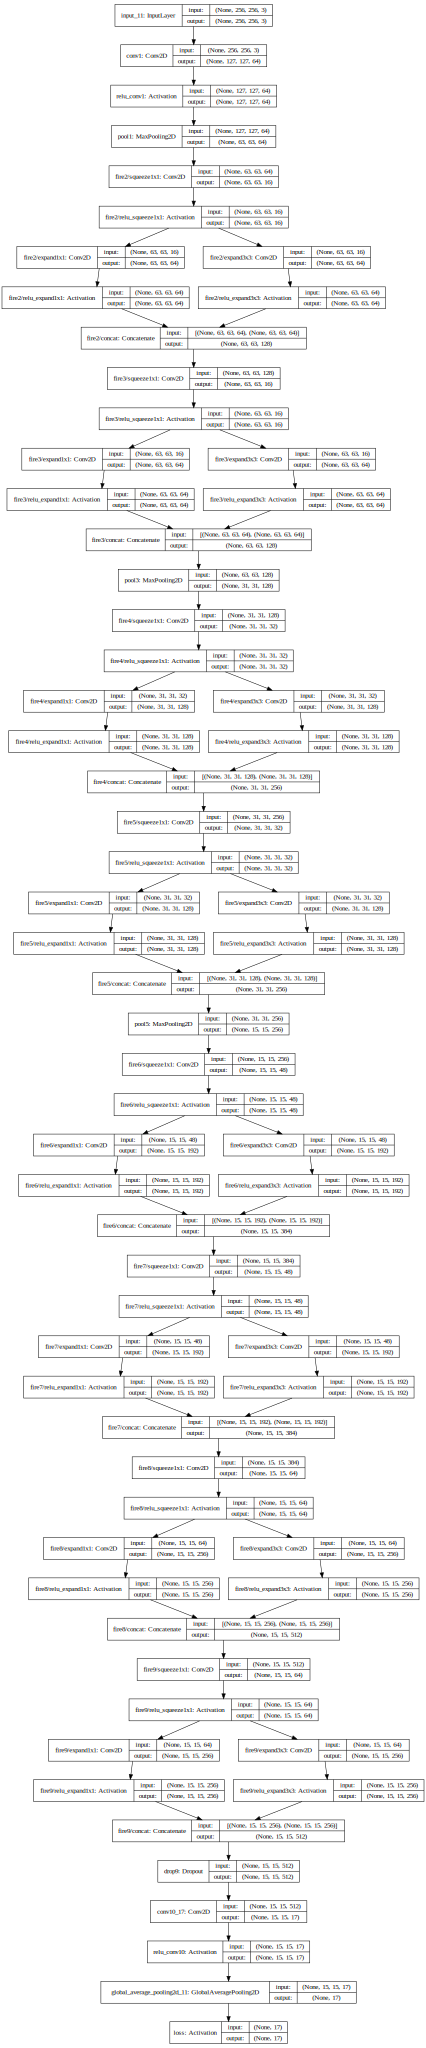

In [45]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

SVG(model_to_dot(cnn, show_shapes=True).create(prog='dot', format='svg'))

## Train on all classes

In [7]:
seed = 2017
np.random.seed(seed)

In [8]:
trainval_id_type_list = [(image_id, "Train_jpg") for image_id in train_jpg_ids]

print(len(trainval_id_type_list))

40479


In [9]:
from data_utils import DataCache

try:
    if cache is None:
        cache_filepath = os.path.join(GENERATED_DATA, 'data_cache.pkl')
        if os.path.exists(cache_filepath):
            print("Load cache from pickle file")
            cache = load_data_cache(cache_filepath)
        else:
            cache = DataCache(20000)
except NameError:
    cache_filepath = os.path.join(GENERATED_DATA, 'data_cache.pkl')
    if os.path.exists(cache_filepath):
        print("Load cache from pickle file")
        cache = load_data_cache(cache_filepath)
    else:
        cache = DataCache(20000)

In [ ]:
params = {
    'seed': seed,
    
    'xy_provider': image_label_provider,
    
    
    'optimizer': 'adadelta',
    'loss': 'categorical_crossentropy',
    'nb_epochs': 300,
    'batch_size': 16,    
    
    'normalize_data': True,
    'normalization': 'vgg',
    
    'image_size': (256, 256),
    
    'lr_kwargs': {
        'lr': 0.01,
        'a': 0.95,
        'init_epoch': 0
    },
    'lr_decay_f': exp_decay,
    
    'cache': cache,
    
    'class_index': 0,
    
#     'pretrained_model': 'load_best'
#     'pretrained_model': os.path.join(GENERATED_DATA, "weights", "")
    
}
params['save_prefix'] = 'squeezenet_seed=%i_all_classes' % params['seed']

params['input_shape'] = params['image_size'] + (3,)
params['n_classes'] = len(unique_tags)

Start CV

In [ ]:
n_folds = 5
val_fold_index = 0
val_fold_indices = [0, ]
hists = []

kf = KFold(n_splits=n_folds, shuffle=True, random_state=params['seed'])
trainval_id_type_list = np.array(trainval_id_type_list)
for train_index, test_index in kf.split(trainval_id_type_list):        
    train_id_type_list, val_id_type_list = trainval_id_type_list[train_index], trainval_id_type_list[test_index]
    
    if len(val_fold_indices) > 0:
        if val_fold_index not in val_fold_indices:
            val_fold_index += 1
            continue
        
    print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
    val_fold_index += 1

    print(len(train_id_type_list), len(val_id_type_list))
    assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"

    print("\n {} - Get squeezenet model ...".format(datetime.now()))
    cnn = get_squeezenet(input_shape=params['input_shape'], 
                         n_classes=params['n_classes'], 
                         optimizer=params['optimizer'],
                         loss=params['loss'],
                         lr=params['lr_kwargs']['lr'])

    if 'pretrained_model' in params:
        if params['pretrained_model'] == 'load_best':
            weights_files = glob(os.path.join(GENERATED_DATA, "weights", "%s*.h5" % params['save_prefix']))
            assert len(weights_files) > 0, "Failed to load weights"
            best_weights_filename, best_val_loss = find_best_weights_file(weights_files, field_name='val_loss')
            print("Load best loss weights: ", best_weights_filename, best_val_loss)
            cnn.load_weights(best_weights_filename)
        else:
            assert os.path.exist(params['pretrained_model']), "Not found pretrained model"
            print("Load weights: ", params['pretrained_model'])
            cnn.load_weights(params['pretrained_model'], by_name=True)

    print("\n {} - Start training ...".format(datetime.now()))
    h = train(cnn, train_id_type_list, val_id_type_list, **params)    
    if h is None:
        continue
    hists.append(h)



 ---- Validation fold index:  0 / 5
32383 8096

 2017-07-03 20:46:04.513155 - Get squeezenet model ...

 2017-07-03 20:46:07.512975 - Start training ...

-- Training parameters: 16, 300, 32384, 8112

-- Fit model
- New Keras API found -

Epoch validation: score = 0.481587 

Epoch 1/300
2024/2024 [==============================] - 2498s - loss: 7.3420 - precision: 0.1711 - recall: 0.9994 - val_loss: 7.1063 - val_precision: 0.3522 - val_recall: 0.9540

Epoch validation: score = 0.690625 

Epoch 2/300
2024/2024 [==============================] - 2452s - loss: 7.1103 - precision: 0.1815 - recall: 0.9970 - val_loss: 7.0433 - val_precision: 0.4935 - val_recall: 0.9316

Epoch validation: score = 0.796569 

Epoch 3/300
2024/2024 [==============================] - 2548s - loss: 7.0644 - precision: 0.1990 - recall: 0.9945 - val_loss: 7.0134 - val_precision: 0.5298 - val_recall: 0.9269

Epoch validation: score = 0.813105 

Epoch 4/300
2024/2024 [==============================] - 2520s - loss: 7

### Validation all classes

In [10]:
n_runs = 1
n_folds = 5
run_counter = 0
cv_mean_scores = np.zeros((n_runs, n_folds))
val_fold_indices = [0,]

In [11]:
while run_counter < n_runs:    
    run_counter += 1
    print("\n\n ---- New run : ", run_counter, "/", n_runs)
    val_fold_index = 0
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=params['seed'])
    trainval_id_type_list = np.array(trainval_id_type_list)
    for train_index, test_index in kf.split(trainval_id_type_list):        
        train_id_type_list, val_id_type_list = trainval_id_type_list[train_index], trainval_id_type_list[test_index]

        if len(val_fold_indices) > 0:
            if val_fold_index not in val_fold_indices:
                val_fold_index += 1
                continue
        
        print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
        val_fold_index += 1

        print(len(train_id_type_list), len(val_id_type_list))
        assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"

        print("\n {} - Get squeezenet model ...".format(datetime.now()))
        cnn = get_squeezenet(input_shape=params['input_shape'], n_classes=params['n_classes'])

        weights_files = glob(os.path.join(GENERATED_DATA, "weights", "%s*.h5" % params['save_prefix']))
        assert len(weights_files) > 0, "Failed to load weights"
        best_weights_filename, best_val_loss = find_best_weights_file(weights_files, field_name='val_loss')
        print("Load best loss weights: ", best_weights_filename, best_val_loss)
        cnn.load_weights(best_weights_filename)

        score = validate(cnn, val_id_type_list, **params)   
        cv_mean_scores[run_counter-1, val_fold_index-1] = score
    
print(cv_mean_scores)



 ---- New run :  1 / 1


 ---- Validation fold index:  0 / 5
1594 399

 2017-07-02 23:53:40.818343 - Get squeezenet model ...
Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/input/generated/weights/squeezenet_seed=2017_class=0_23_val_loss=0.6935_precision=0.0366_recall=0.3256.h5 0.6935
Image normalization:  vgg
Total score :  0.0870158196523
[[ 0.08701582  0.          0.          0.          0.        ]]


### Visual validation

In [27]:
from training_utils import get_val_imgaug_seq, get_gen_flow
from image_utils import scale_percentile

import matplotlib.pylab as plt
%matplotlib inline

In [28]:
cnn = get_squeezenet(input_shape=params['input_shape'], n_classes=params['n_classes'])

weights_files = glob(os.path.join(GENERATED_DATA, "weights", "%s*.h5" % params['save_prefix']))
assert len(weights_files) > 0, "Failed to load weights"
best_weights_filename, best_val_loss = find_best_weights_file(weights_files, field_name='val_loss')
print("Load best loss weights: ", best_weights_filename, best_val_loss)
cnn.load_weights(best_weights_filename)

Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/input/generated/weights/squeezenet_seed=2017_class=0_172_val_loss=1.3980_precision=0.0852_recall=0.9872.h5 1.398


In [29]:
imgaug_seq = get_val_imgaug_seq(seed=params['seed'])
val_gen, val_flow = get_gen_flow(id_type_list=train_id_type_list, 
                                     imgaug_seq=imgaug_seq, 
                                     test_mode=True, **params)
channels_first = False


-- ('30627', 'Train_jpg')
y_true:  [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
y_pred:  [ 0.93356311  0.          0.20272397  0.          0.          0.9995715   0.
  0.99980915  0.99999499  0.          0.          0.          0.          0.
  0.99998558  0.58036947  0.91474366]

-- ('15050', 'Train_jpg')
y_true:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
y_pred:  [ 0.57105637  0.          0.99868751  0.0608026   0.          0.21037248
  0.          0.99050289  0.98420787  0.          0.01730899  0.00800789
  0.30372357  0.00819117  0.95201802  0.01136751  0.02252713]

-- ('21274', 'Train_jpg')
y_true:  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
y_pred:  [  7.15842366e-01   2.37912376e-04   4.16824996e-01   3.34923007e-02
   6.48336485e-04   3.44256073e-01   4.73223114e-03   9.47760761e-01
   9.66103196e-01   0.00000000e+00   3.91717395e-03   7.01480173e-03
   4.33282368e-03   4.93883202e-03   9.54560280e-01   7.72575438e-02
   1.64204165e-01]

-- ('17105', 'Train_jpg')
y_true:  [0 0 0 0 0 0 0 0 0 0 0 0 0

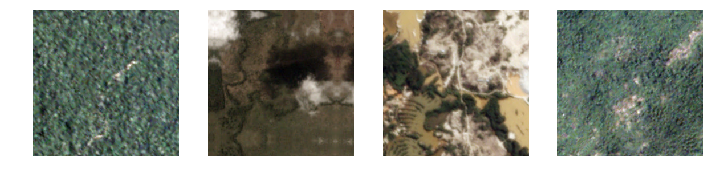

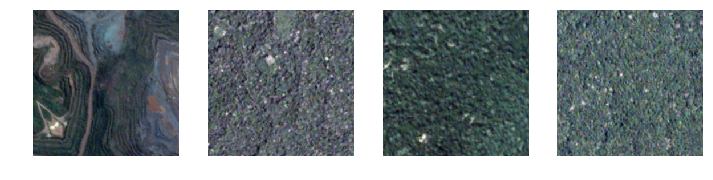

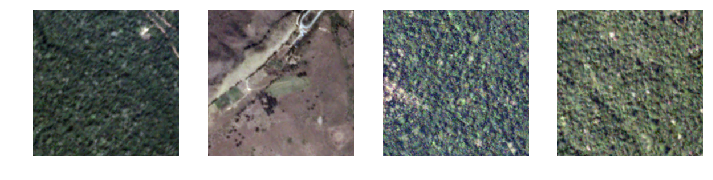

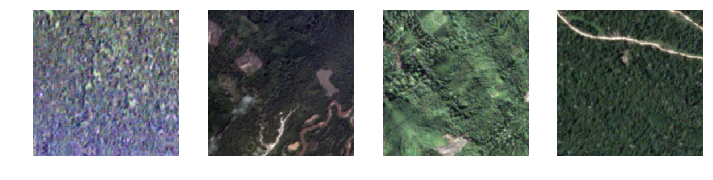

In [30]:
loop_max_counter = 1
for x, y_true, info in val_flow:
        
    y_pred = cnn.predict_on_batch(x)
    n = 4
    for counter in range(params['batch_size']):
        print("\n--", info[counter])
        print('y_true: ', y_true[counter, :])
        print('y_pred: ', y_pred[counter, :])        
        if counter % n == 0:
            plt.figure(figsize=(12, 4))
        plt.subplot(1, n, counter % n + 1)
        if channels_first:
            img = x[counter, :, :, :].transpose([1, 2, 0])
        else:
            img = x[counter, :, :, :]
        plt.imshow(scale_percentile(img, q_min=0.0, q_max=100.0))
#         plt.imshow(img)        
        plt.axis('off')
    
    loop_max_counter -= 1
    if loop_max_counter == 0:
        break
    